# Methods

In [1]:
import numpy as np
from numpy import random
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcdefaults()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("font", size=12)
plt.rc("axes", edgecolor="white")
#plt.rc("grid", alpha=0.5)
plt.rc("legend", frameon=True, framealpha=0.8, facecolor="white", edgecolor="white")

#### Forward Euler

In [2]:
def forwardEuler(f, state0, t):
    '''
    Returns array of states approximated with the forward Euler method.

    f ........ function of ODE state'(t) = f(t, state(t))
    state0 ... initial value state(t0) = state0
    t ........ discretized interval [t0, t1, ...]
    '''

    N = len(t)
    dim = (N,) + np.shape(state0)
    
    states = np.zeros(dim)
    states[0] = state0

    for n in range(N-1):
        h = t[n+1] - t[n]
        states[n+1] = states[n] + h * f(t[n], states[n])

    return states

#### Backward Euler

In [3]:
def fixedPointIter(f, x0, *args, tol=1e-8, iters=10000):
    '''
    Returns approximated fixed point of given function if found using a simple iteration.

    f ....... function with iterator as first positional argument
    x0 ...... initial value of iteration
    *args ... pass-through arguments of f
    tol ..... tolerance of approximation to stop iterating
    iters ... maximum number of iterations before divergence is declared
    '''

    dim = (iters,) + np.shape(x0)
    
    x = np.zeros(dim)
    x[0] = x0

    for i in range(iters):
        x[i+1] = f(x[i], *args)

        if np.allclose(x[i+1], x[i], atol=tol):
            return x[i+1]

    else:
        print(f"Fixed-point iteration did not converge in {iters} iterations. Returned last value.")
        return x[i+1]

In [4]:
def backwardEuler(f, state0, t, tol=1e-8, iters=10000):
    '''
    Returns array of states approximated with the backward Euler method using a fixed point iteration.

    f ........ function of ODE state'(t) = f(t, state(t))
    state0 ... initial value state(t0) = state0
    t ........ discretized interval [t0, t1, ...]
    tol ...... tolerance of approximation to stop iterating
    iters .... maximum number of iterations before divergence is declared
    '''

    N = len(t)
    dim = (N,) + np.shape(state0)

    states = np.zeros(dim)
    states[0] = state0
    
    for n in range(N-1):
        h = t[n+1] - t[n]
        
        def g(x):
            return states[n] + h * f(t[n], x)
        
        states[n+1] = fixedPointIter(g, states[n], tol=tol, iters=iters)

    return states

#### Trapezoidal Rule

In [7]:
def trapezoidalRule(f, state0, t, tol=1e-8, iters=10000):
    '''
    Returns array of states approximated with the trapezoidal rule using a fixed point iteration.

    f ........ function of ODE state'(t) = f(t, state(t))
    state0 ... initial value state(t0) = state0
    t ....... discretized interval [t0, t1, ...]
    tol ..... tolerance of approximation to stop iterating
    iters ... maximum number of iterations before divergence is declared
    '''

    N = len(t)
    dim = (N,) + np.shape(state0)

    states = np.zeros(dim)
    states[0] = state0
    
    for n in range(N-1):
        h = t[n+1] - t[n]
        
        def g(x):
            return states[n] + h * (f(t[n], states[n]) + f(t[n+1], x)) / 2
        
        states[n+1] = fixedPointIter(g, states[n], tol=tol, iters=iters)

    return states

#### Runge-Kutta 4

In [8]:
def RungeKutta4(f, state0, t):
    '''
    Returns array of states approximated with the Runge-Kutta method of 4th order.

    f ........ function of ODE state'(t) = f(t, state(t))
    state0 ... initial value state(t0) = state0
    t .... discretized interval [t0, t1, ...]
    '''
    
    N = len(t)
    dim = (N,) + np.shape(state0)
    
    states = np.zeros(dim)
    states[0] = state0

    for n in range(N-1):
        h = t[n+1] - t[n]
        
        k1 = f(t[n], states[n])
        k2 = f(t[n] + h/2, states[n] + h/2 * k1)
        k3 = f(t[n] + h/2, states[n] + h/2 * k2)
        k4 = f(t[n] + h, states[n] + h * k3)
        
        states[n+1] = states[n] + h/6 * (k1 + 2*k2 + 2*k3 + k4)
    
    return states

#### Predictor-Corrector

In [9]:
def ABM(f, state0, t, steps=4, iters=1, tol=1e-8):
    '''
    Returns array of states solved using the predictor-corrector method: Adams-Bashforth-Moulton.

    f ........ function of the ODE: y' = f(t, y)
    state0 ... initial state vector [state0_1, state0_2, ...]
    t ........ discretized time interval [t0, t1, ...]
    steps .... number of interpolation steps per time step
    iters .... number of iterations for each correction-evaluation cycle
    tol ...... if this tolerance is met the correction-evaluation cycle stops
    '''

    # input processing
    s = int(steps) if 1 <= steps <= 4 else 4
    iters = int(iters) if 0 < iters else 1
    N = len(t)
    dim = (N,) + np.shape(state0)
        
    # initialize state array with initial states
    states = np.zeros(dim)
    if s == 1:
        states[0] = state0
    else:
        states[:s] = RungeKutta4(f, state0, t[:s])
    
    # initialize ODE function values
    fvals = np.zeros(dim)
    for n in range(s):
        fvals[n] = f(t[n], states[n])

    # coefficients for Adams-Bashforth method
    coeffsAB = (1,
                [-1/2, 3/2],
                [5/12, -16/12, 23/12],
                [-9/24, 37/24, -59/24, 55/24])
    
    # coefficients for Adams-Moulton method
    coeffsAM = ([1/2, 1/2],
                [-1/12, 2/3, 5/12],
                [1/24, -5/24, 19/24, 9/24],
                [-19/720, 106/720, -264/720, 646/720, 251/720])

    # prediction-correction cycle
    for n in range(s-1, N-1):
        h = t[n+1] - t[n]
        
        # predictor: Adams-Bashforth method
        states[n+1] = states[n] + h * np.dot(coeffsAB[s-1], fvals[n-s+1:n+1])

        # evaluation
        fvals[n+1] = f(t[n+1], states[n+1])

        # correction-evaluation cycle with Adams-Moulton
        for _ in range(iters):
            new = states[n] + h * np.dot(coeffsAM[s-1], fvals[n-s+1:n+2])
            cond = np.allclose(new, states[n+1], atol=tol) if iters > 1 else 1
            states[n+1] = new
            fvals[n+1] = f(t[n+1], states[n+1])
            if cond:
                break

    return states

In [10]:
def ABM4(f, state0, t):

    N = len(t)
    dim = (N,) + np.shape(state0)
        
    # initialize state array with initial values
    states = np.zeros(dim)
    states[:4] = RungeKutta4(f, state0, t[:4])
    
    # initialize ODE function value array
    fvals = np.zeros(dim)
    for n in range(4):
        fvals[n] = f(t[n], states[n])

    # prediction-correction cycle
    for n in range(3, N-1):
        h = t[n+1] - t[n]
        
        # predictor: Adams-Bashforth method
        states[n+1] = states[n] + h/24 * (55*fvals[n] - 59*fvals[n-1] + 37*fvals[n-2] - 9*fvals[n-3])

        # evaluation
        fvals[n+1] = f(t[n+1], states[n+1])

        # corrector: Adams-Moulton
        states[n+1] = states[n] + h/720 * (251*fvals[n+1] + 646*fvals[n] - 264*fvals[n-1] + 106*fvals[n-2] - 19*fvals[n-3])
        
        #evaluation
        fvals[n+1] = f(t[n+1], states[n+1])

    return states

# Plotting

In [11]:
def ParametricPlot(*args, labels=None, title="", linewidth=1.5, alpha=0.95, size=(6.4, 4.8), fname=None):
    
    fig = plt.figure(figsize=size)
    ax = fig.gca(projection="3d")

    ax.w_xaxis.pane.set_color("w")
    ax.w_yaxis.pane.set_color("w")
    ax.w_zaxis.pane.set_color("w")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title(f"{title}", pad=16)

    for i, states in enumerate(args):
        if labels is None:
            ax.plot(*states.T, alpha=alpha, linewidth=linewidth)
        else:
            ax.plot(*states.T, alpha=alpha, linewidth=linewidth, label=f"{labels[i]}")

    if labels is not None:
        plt.legend(loc="upper left")
    
    if fname is not None:
        fig.savefig(fname, bbox_inches="tight")

    plt.show()

In [12]:
def Plot(t, *args, labels=None, title="", sameAxis=True, linewidth=1.5, size=(6.4, 4.8), fname=None):
    
    fig = plt.figure(figsize=size)
    ax1 = fig.add_subplot(3, 1, 1, xticklabels=[])
    ax2 = fig.add_subplot(3, 1, 2, xticklabels=[])
    ax3 = fig.add_subplot(3, 1, 3)

    ax1.set_title(f"{title}", pad=24)
    ax1.set_ylabel("x")
    ax2.set_ylabel("y")
    ax3.set_ylabel("z")
    ax3.set_xlabel("t")
    
    
    if sameAxis:
        for i, states in enumerate(args):
            if labels is None:
                ax1.plot(t, states.T[0], color=f"C{i}", linewidth=linewidth)
            else:
                ax1.plot(t, states.T[0], color=f"C{i}", linewidth=linewidth, label=f"{labels[i]}")
            ax2.plot(t, states.T[1], color=f"C{i}", linewidth=linewidth)
            ax3.plot(t, states.T[2], color=f"C{i}", linewidth=linewidth)
    
    else:
        for i, states in enumerate(args):
            if labels is None:
                ax1.plot(t[i], states.T[0], color=f"C{i}", linewidth=linewidth)
            else:
                ax1.plot(t[i], states.T[0], color=f"C{i}", linewidth=linewidth, label=f"{labels[i]}")
            ax2.plot(t[i], states.T[1], color=f"C{i}", linewidth=linewidth)
            ax3.plot(t[i], states.T[2], color=f"C{i}", linewidth=linewidth)
    
    if labels is not None:
        ax1.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", ncol=len(args), mode="expand", borderaxespad=0)
    
    if fname is not None:
        fig.savefig(fname, bbox_inches="tight")

    plt.show()

# System

In [13]:
def LorenzSystem(sigma, rho, beta):
    def ODE(t, state):
        x, y, z = state
        return np.array([sigma*(y-x), x*(rho-z)-y, x*y-beta*z])
    return ODE

# Graphs

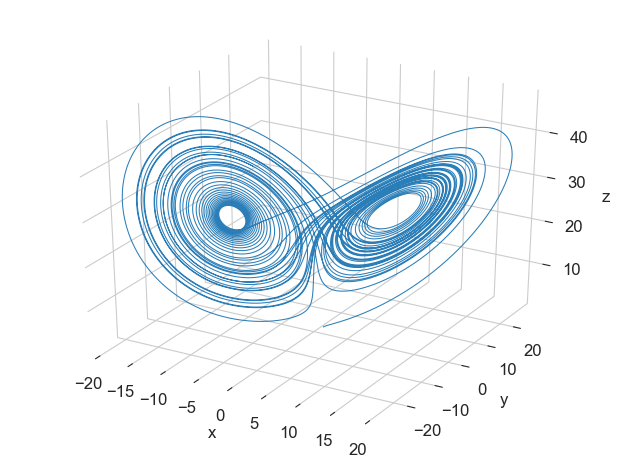

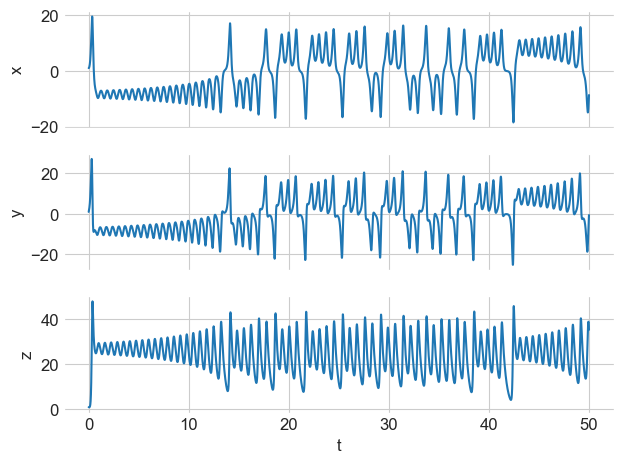

In [194]:
f = LorenzSystem(10, 28, 8/3)

state0 = (1, 1, 1)
t = np.arange(0, 50, 0.001)

states = RungeKutta4(f, state0, t)

ParametricPlot(states, linewidth=0.75)
Plot(t, states)

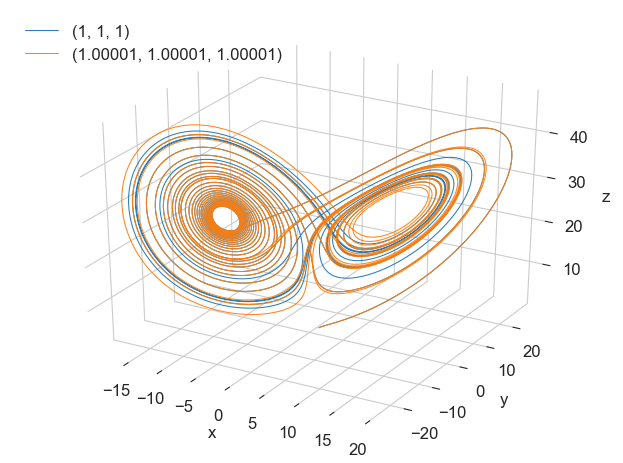

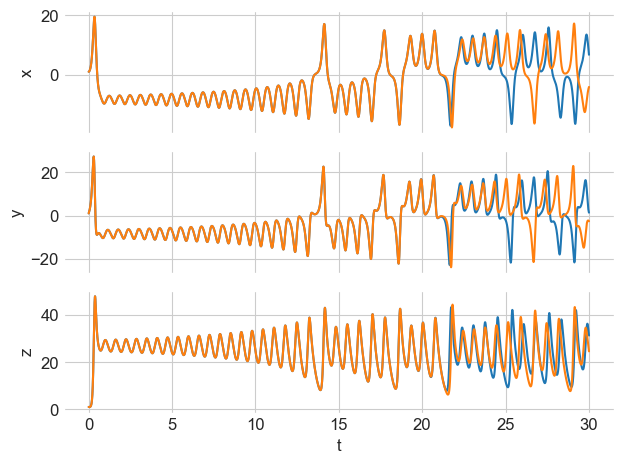

In [195]:
f = LorenzSystem(10, 28, 8/3)

delta = 0.00001
state1 = (1, 1, 1)
state2 = (1+delta, 1+delta, 1+delta)
t = np.arange(0, 30, 0.001)

states1 = RungeKutta4(f, state1, t)
states2 = RungeKutta4(f, state2, t)

labels = (str(state1), str(state2))
ParametricPlot(states1, states2, linewidth=0.75, labels=labels)
Plot(t, states1, states2)

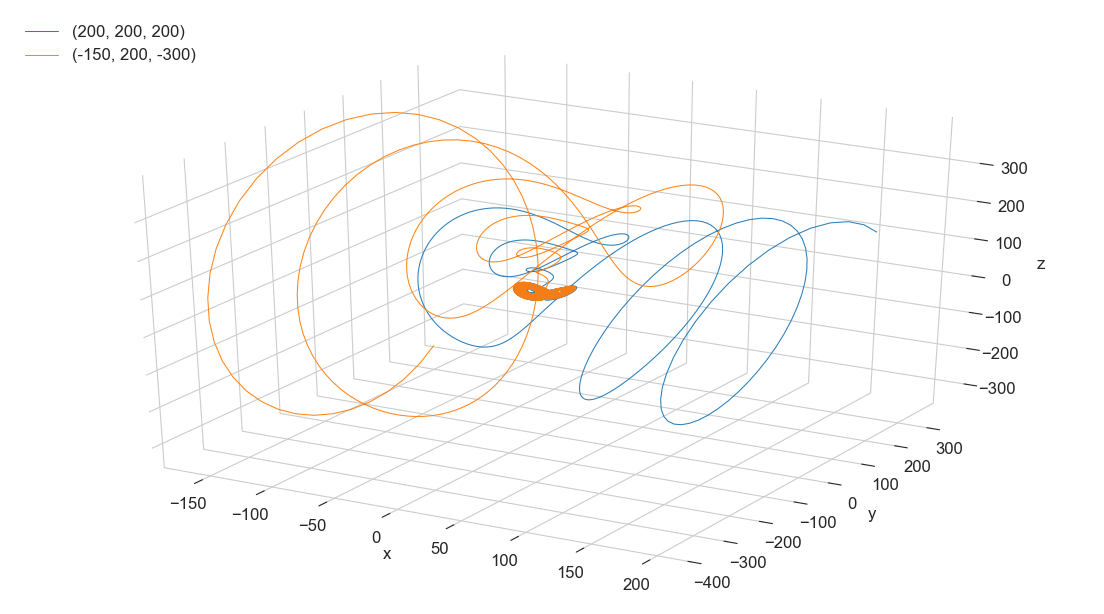

In [196]:
f = LorenzSystem(10, 28, 8/3)

state1 = (200, 200, 200)
state2 = (-150, 200, -300)
t = np.arange(0, 100, 0.001)

states1 = RungeKutta4(f, state1, t)
states2 = RungeKutta4(f, state2, t)

labels = (str(state1), str(state2))
ParametricPlot(states1, states2, labels=labels, linewidth=0.75, size=(11.2, 6.3))

In [197]:
def plotR(r, T=10, linewidth=1.5):
    f = LorenzSystem(10, r, 8/3)
    
    state1 = (10, 10, 10)
    state2 = (-5, -5, -5)
    state3 = (10, -5, -5)
    t = np.arange(0, T, 0.001)
    
    states1 = RungeKutta4(f, state1, t)
    states2 = RungeKutta4(f, state2, t)
    states3 = RungeKutta4(f, state3, t)
    
    labels = (str(state1), str(state2), str(state3))
    ParametricPlot(states1, states2, states3, labels=labels, linewidth=linewidth)
    Plot(t, states1, states2, states3)

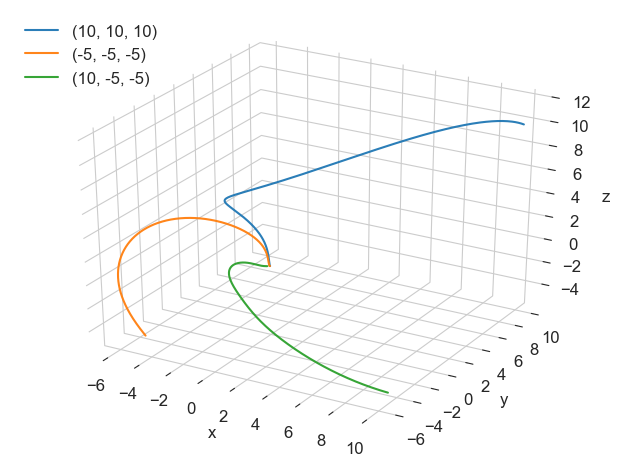

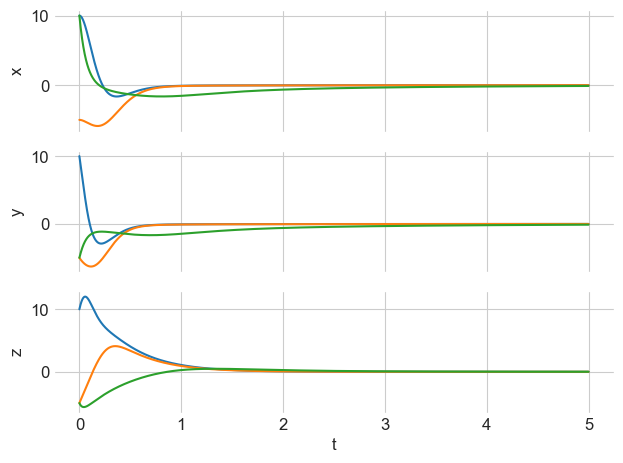

In [201]:
plotR(0.5, T=5)

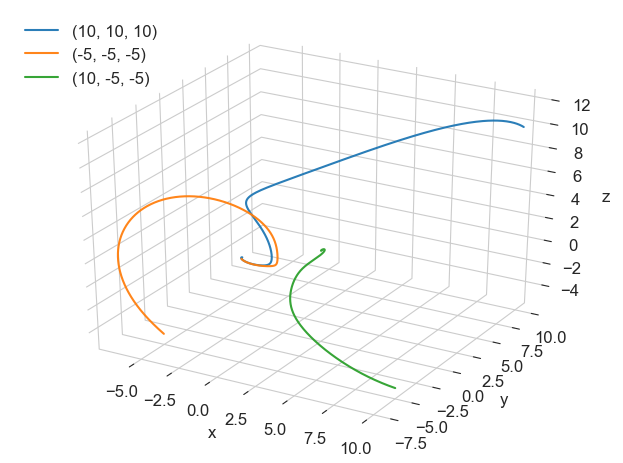

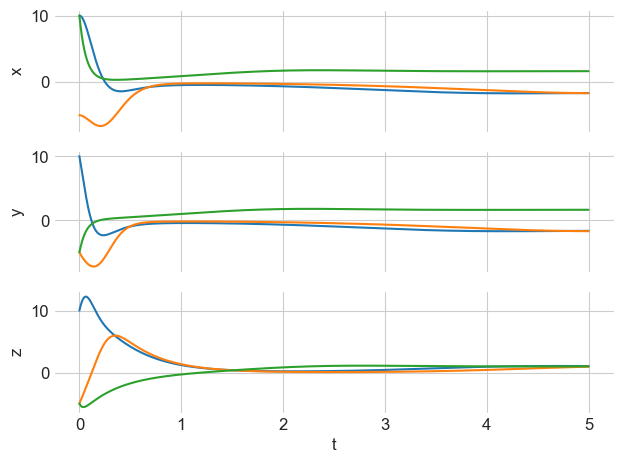

In [202]:
plotR(2, T=5)

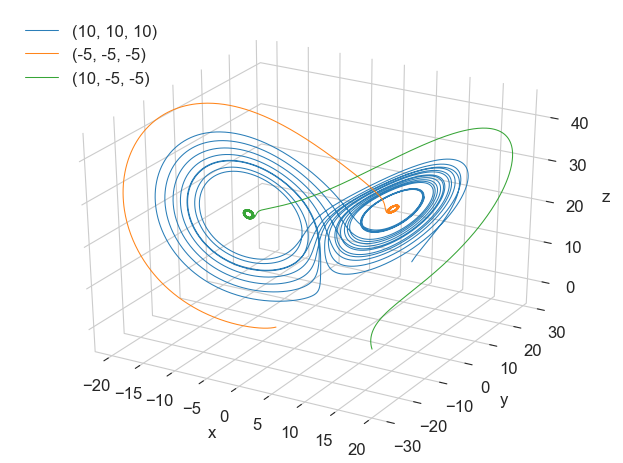

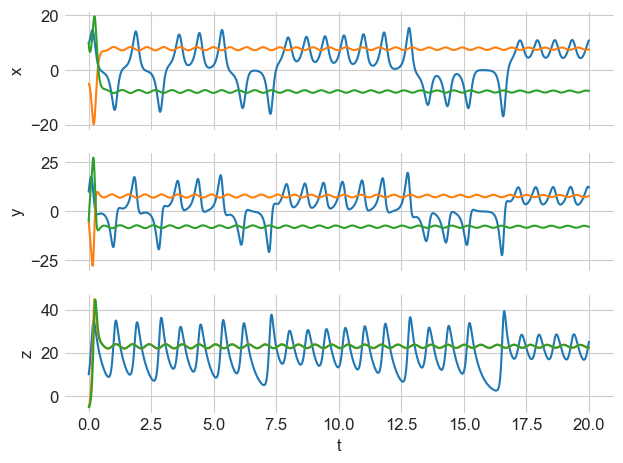

In [203]:
plotR(24, T=20, linewidth=0.75)

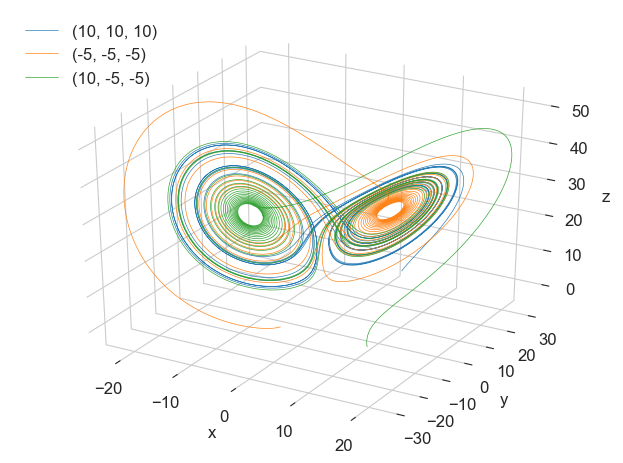

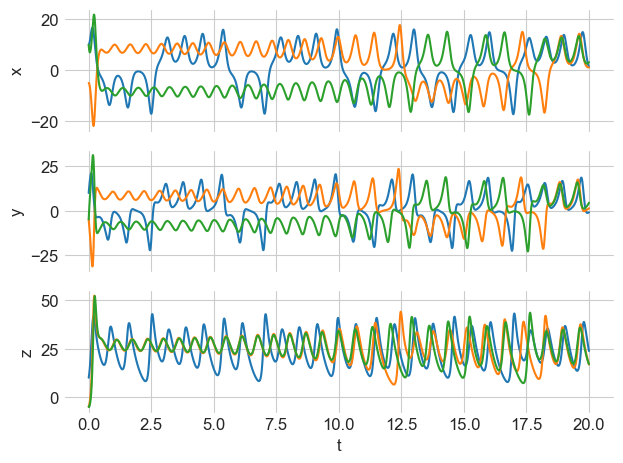

In [204]:
plotR(28, T=20, linewidth=0.5)

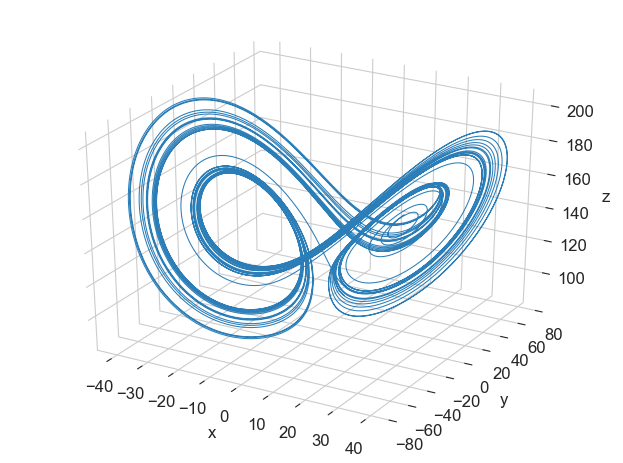

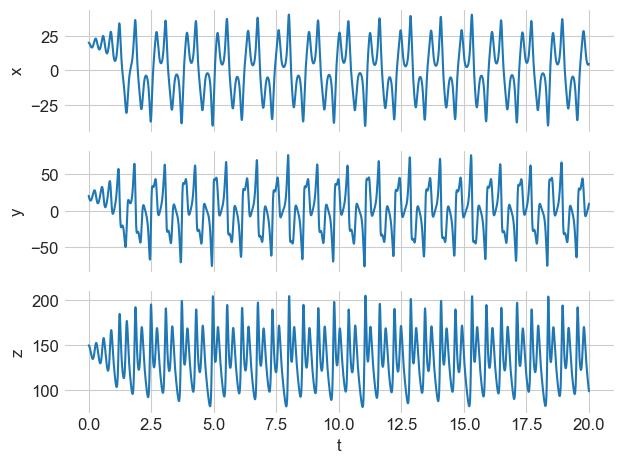

In [205]:
f = LorenzSystem(10, 144, 8/3)

state0 = (20, 20, 150)
t = np.arange(0, 20, 0.001)

states = RungeKutta4(f, state0, t)

ParametricPlot(states, linewidth=0.75)
Plot(t, states)

# Sensitivity

In [130]:
f = LorenzSystem(10, 28, 8/3)

delta = 1e-08
state1 = np.array([5, 5, 25])
state2 = state1 + delta
t = np.arange(0, 40, 0.001)

states1 = ABM4(f, state1, t)
states2 = ABM4(f, state2, t)

diffs = states1 - states2
norms = [sum([s**2 for s in diff]) for diff in diffs]

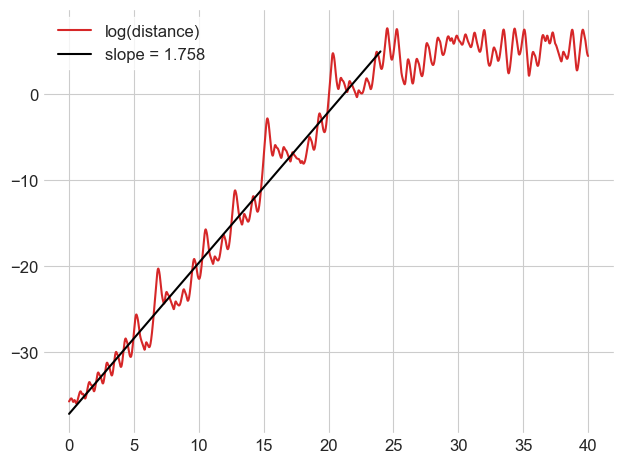

In [131]:
a = 0
b = 24_001
coef = np.polyfit(t[a:b], np.log(norms[a:b]), 1)
line = np.poly1d(coef) 

plt.plot(t, np.log(norms), label="log(distance)", color="C3")
plt.plot(t[a:b], line(t[a:b]), label=f"slope = {coef[0]:.3f}", color="k")
plt.legend()
plt.show()

# Comparison

In [55]:
M = 65536
Ns = [ 1024, 2048, 4096, 8192, 16384]
divsFE = (13.021484375, 13.060546875, 13.333251953125, 14.15087890625, 16.007080078125)
divsBE = (13.52734375, 13.64404296875, 13.756591796875, 13.8533935546875, 13.93878173828125)
divsTR = (21.484375, 21.4951171875, 23.583984375, 26.5889892578125, 28.009765625)
divsRK = (32.685546875, 33.6728515625, 36.01171875, 41.81005859375, 42.89483642578125)
divsPC = (30.466796875, 33.53759765625, 35.96533203125, 41.8863525390625, 45.19171142578125)
timesFE = (0.609375, 1.265625, 2.484375, 4.953125, 9.859375)
timesBE = (11.6875, 22.65625, 36.515625, 68.703125, 132.640625)
timesTR = (13.3125, 22.765625, 40.515625, 77.796875, 152.640625)
timesRK = (2.71875, 5.421875, 10.828125, 21.578125, 42.671875)
timesPC = (2.671875, 5.3125, 10.640625, 21.203125, 42.453125)

In [56]:
def order(divs):

    return (np.log(divs[-1]) - np.log(divs[0])) / (np.log(Ns[-1]) - np.log(Ns[0]))

def fit(divs):
    p = order(divs)
    c = divs[0] / Ns[0]**p
    def func(x):
        return c*x**p
    return func

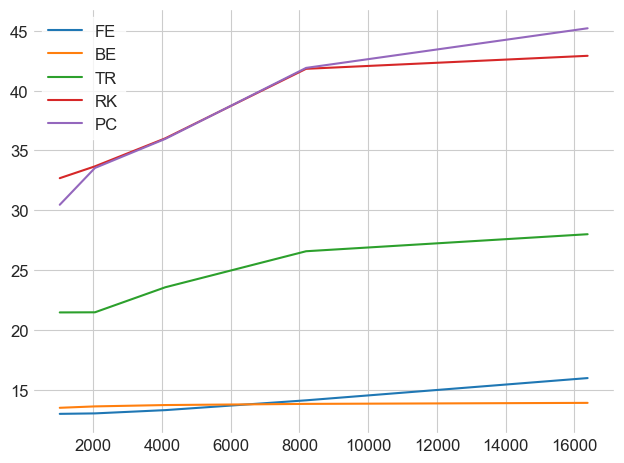

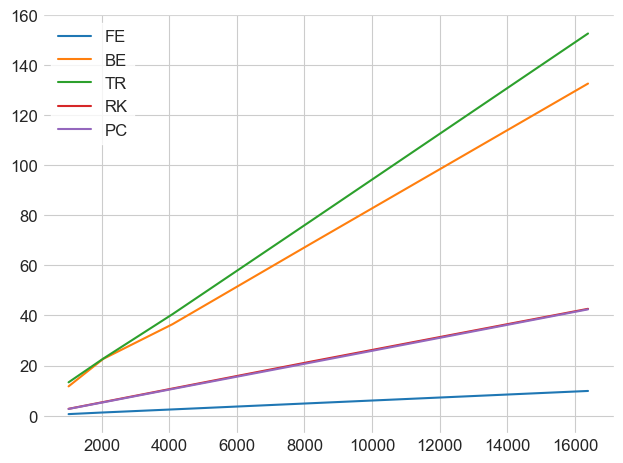

In [57]:
plt.plot(Ns, divsFE, label="FE")
plt.plot(Ns, divsBE, label="BE")
plt.plot(Ns, divsTR, label="TR")
plt.plot(Ns, divsRK, label="RK")
plt.plot(Ns, divsPC, label="PC")
plt.legend()
plt.show()

plt.plot(Ns, timesFE, label="FE")
plt.plot(Ns, timesBE, label="BE")
plt.plot(Ns, timesTR, label="TR")
plt.plot(Ns, timesRK, label="RK")
plt.plot(Ns, timesPC, label="PC")
plt.legend()
plt.show()

In [58]:
print("FE: ", order(divsFE))
print("BE: ", order(divsBE))
print("TR: ", order(divsTR))
print("RK: ", order(divsRK))
print("PC: ", order(divsPC))

FE:  0.07445406165428954
BE:  0.010806474149423675
TR:  0.09566052578272276
RK:  0.09803778860820551
PC:  0.14220509076771912


In [59]:
fitFE = fit(divsFE)
fitBE = fit(divsBE)
fitTR = fit(divsTR)
fitRK = fit(divsRK)
fitPC = fit(divsPC)

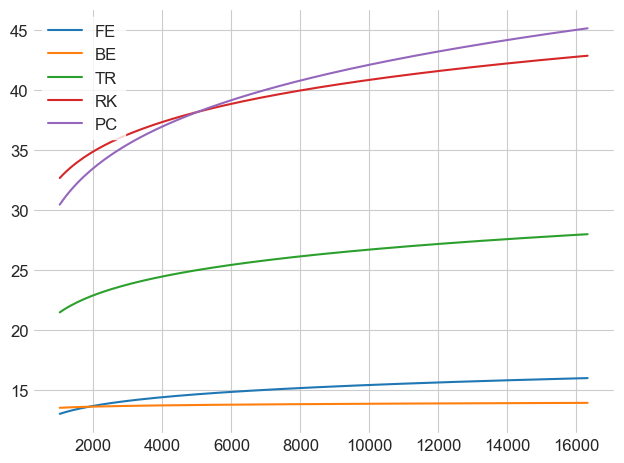

In [62]:
x = np.arange(1024, 16384, 100)
plt.plot(x, fitFE(x), label="FE")
plt.plot(x, fitBE(x), label="BE")
plt.plot(x, fitTR(x), label="TR")
plt.plot(x, fitRK(x), label="RK")
plt.plot(x, fitPC(x), label="PC")
plt.legend()
plt.show()